## Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import csv

## Files

In [32]:
spike_dataset = "M1F" # edit as necessary
dataset = ["RC", "RNB", "YC", "YNB"]
region = ["A", "I", "P", "S", "D"]

path = "./" + spike_dataset + "/" + spike_dataset + " Data - " 
files = [d + " " + r for d in dataset for r in region]

## Data

In [33]:
jaw_markers = ['AnteriorMandibleR', 'AnteriorMandibleL', 'PosteriorMandibleR', 'PosteriorMandibleL']
anterior_markers = ['AnteriorM', 'AnteriorSuperficialR', 'AnteriorSuperficialL', 'AnteriorDeepR', 
                    'AnteriorDeepL']
r_intermediate_markers = ['IntermediateSuperficialR', 'IntermediateSuperficialM', 'IntermediateSuperficialL', 'IntermediateDeepM', 
                          'IntermediateLateralR', 'IntermediateLateralL']
y_intermediate_markers = ['IntermediateSuperficialR', 'IntermediateSuperficialM', 'IntermediateSuperficialL', 'IntermediateDeepM', 
                          'IntermediateLateralL']
posterior_markers = ['PosteriorSuperficialM', 'PosteriorDeepM', 'PosteriorLateralR', 
                     'PosteriorLateralL']
superficial_markers = ['AnteriorSuperficialR', 'AnteriorSuperficialL', 'IntermediateSuperficialR', 'IntermediateSuperficialM', 
                       'IntermediateSuperficialL', 'PosteriorSuperficialM']
r_deep_markers = ['AnteriorDeepR', 'AnteriorDeepL', 'IntermediateDeepM', 'PosteriorDeepM', 'IntermediateLateralR', 'IntermediateLateralL', 
                  'PosteriorLateralR', 'PosteriorLateralL']
y_deep_markers = ['AnteriorDeepR', 'AnteriorDeepL', 'IntermediateDeepM', 'PosteriorDeepM', 'IntermediateLateralL', 
                  'PosteriorLateralR', 'PosteriorLateralL']

In [34]:
raw_data = {}
for f in files:
    curr_file = csv.DictReader(open(path + f + ".csv"))
    for row in curr_file:
        values = list(row.values())
        raw_data[f] = values

In [35]:
xyz = ['X', 'Y', 'Z']

def XYZ(markers):
    data = {
        'X': np.asarray([markers[i] for i in range(0, len(markers), 3)], dtype=float),
        'Y': np.asarray([markers[i + 1] for i in range(0, len(markers), 3)], dtype=float),
        'Z': np.asarray([markers[i + 2] for i in range(0, len(markers), 3)], dtype=float),
    }
    return data

def cat_XYZ(*args):
    data = {
        'X': np.concatenate(([arg['X'] for arg in args])).astype(float),
        'Y': np.concatenate(([arg['Y'] for arg in args])).astype(float),
        'Z': np.concatenate(([arg['Z'] for arg in args])).astype(float),
    }
    return data

region_to_xyz = {}
for f in files:
    if 'A' in f or 'P' in f:
        key = f.split()[0] + ' J'
        if key in region_to_xyz:
            region_to_xyz[key] = cat_XYZ(region_to_xyz[key], XYZ(raw_data[f][:6]))
        else:
            region_to_xyz[key] = XYZ(raw_data[f][:6])
        region_to_xyz[f] = XYZ(raw_data[f][6:])
    else:
        region_to_xyz[f] = XYZ(raw_data[f])

dataset_to_xyz = {}
for d in dataset:
    relevant = []
    for f in files:
        if d in f:
            relevant.append(region_to_xyz[f])
    dataset_to_xyz[d] = cat_XYZ(*relevant)

## Functions

In [37]:
def avg_pctdec(c, nb):
    diff = np.subtract(c, nb)
    div = diff / c
    return np.mean(div) * 100

In [38]:
def make_plot1(rc, rnb, yc, ynb):
    colors = ['blue', 'orange', 'green']
    rocky = []
    yosemite = []
    for i in range(len(xyz)):
        rocky.append(avg_pctdec(rc[xyz[i]], rnb[xyz[i]]))
        yosemite.append(avg_pctdec(yc[xyz[i]], ynb[xyz[i]]))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Monkey R')
    plt.ylabel('Average Decoding Performance Degradation')
    plt.ylim(0, 100)
    plt.bar(xyz, rocky, color=colors)

    plt.subplot(1, 2, 2)
    plt.title('Monkey Y')
    plt.ylim(0, 100)
    plt.bar(xyz, yosemite, color=colors)

In [39]:
def comp_arrays(arr1, arr2, col):
    min, max, min_col, max_col = [], [], [], []
    for i in range(len(arr1)):
        if arr1[i] < arr2[i]:
            min.append(arr1[i])
            max.append(arr2[i])
            min_col.append(col)
            max_col.append('w')
        else:
            min.append(arr2[i])
            max.append(arr1[i])
            min_col.append('w')
            max_col.append(col)
    
    return min, max, min_col, max_col

In [40]:
def make_plot2(markers_r, markers_y, datac_r, datanb_r, datac_y, datanb_y, title, stat):

    x_r = np.arange(len(markers_r))  # the label locations
    x_y = np.arange(len(markers_y))
    width = 0.25  # the width of the bars
    colors = {'X': 'blue', 'Y': 'orange', 'Z': 'green'}

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)

    multiplier = 0
    for attribute, measurement in datac_r.items():
        offset = width * multiplier
        min, max, min_col, max_col = comp_arrays(measurement, datanb_r[attribute], colors[attribute])
        ax1.bar(x_r + offset, max, width - 0.05, color=max_col, edgecolor = colors[attribute], label=attribute)
        ax1.bar(x_r + offset, min, width - 0.05, color=min_col, edgecolor = colors[attribute])
        multiplier += 1

    multiplier = 0
    for attribute, measurement in datac_y.items():
        offset = width * multiplier
        min, max, min_col, max_col = comp_arrays(measurement, datanb_y[attribute], colors[attribute])
        ax2.bar(x_y + offset, max, width - 0.05, color=max_col, edgecolor = colors[attribute], label=attribute)
        ax2.bar(x_y + offset, min, width - 0.05, color=min_col, edgecolor = colors[attribute])
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_ylabel(stat)
    ax1.set_ylim(top=1)
    plt.suptitle(title)
    ax1.set_title('Rocky')
    for i in xyz:
        ax1.axhline(np.mean(datac_r[i]), color=colors[i])
        ax1.axhline(np.mean(datanb_r[i]), color=colors[i], linestyle='--')
    ax1.set_xticks(x_r + width, markers_r, rotation=30, ha='right')
    ax1.legend(loc='lower right', ncols=3)

    ax2.set_ylim(top=1)
    ax2.set_title('Yosemite')
    for i in xyz:
        ax2.axhline(np.mean(datac_y[i]), color=colors[i])
        ax2.axhline(np.mean(datanb_y[i]), color=colors[i], linestyle='--')
    ax2.set_xticks(x_y + width, markers_y, rotation=30, ha='right')
    ax2.legend(loc='lower right', ncols=3)

In [41]:
def get_frame(regions, features, data):
    feature = []
    region = []
    values = []
    for r in regions:
        for i in range(3):
            region.append(r)
        feature.append(features[0])
        feature.append(features[1])
        feature.append(features[2])
    for d in data:
        values.append(np.mean(d['X']))
        values.append(np.mean(d['Y']))
        values.append(np.mean(d['Z']))
    dict = {
        'Axis': feature,
        'Region': region,
        'Values': values
    }

    return pd.DataFrame(dict)

In [42]:
def make_plot3(frame_c, frame_nb, title):
    heatmap_c = frame_c.pivot(columns='Axis',index='Region', values='Values')
    heatmap_nb = frame_nb.pivot(columns='Axis',index='Region', values='Values')

    plt.figure(figsize=(8, 4))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.title('Control')
    sns.heatmap(heatmap_c, vmin = 0, vmax = 1, annot=True, cmap='inferno')
    plt.subplot(1, 2, 2)
    plt.title('Nerve Block')
    sns.heatmap(heatmap_nb, vmin = 0, vmax = 1, annot=True, cmap='inferno')
    plt.show()

In [43]:
def print_stats(title, *datasets):
    if len(datasets) > 2:
        stat, p = scipy.stats.kruskal(*datasets)
    else:
        stat, p = scipy.stats.mannwhitneyu(*datasets)
    mult = ''
    if p < 0.05 and len(datasets) > 2:
        mult = scipy.stats.tukey_hsd(*datasets)
    elif p < 0.05:
        mult = 'Significant'

    print(title)
    print()
    print('H Statistic: ' + str(stat))
    print('P-Value: ' + str(p))
    print()
    print(mult)
    print()
    return float(stat)

## Figure 1

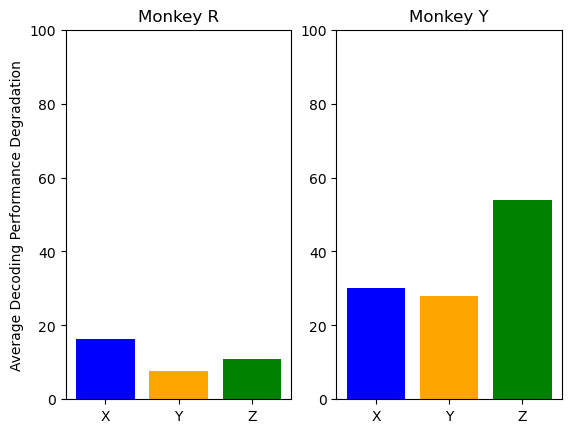

In [44]:
make_plot1(dataset_to_xyz['RC'], dataset_to_xyz['RNB'], dataset_to_xyz['YC'], dataset_to_xyz['YNB'])

## Figure 2

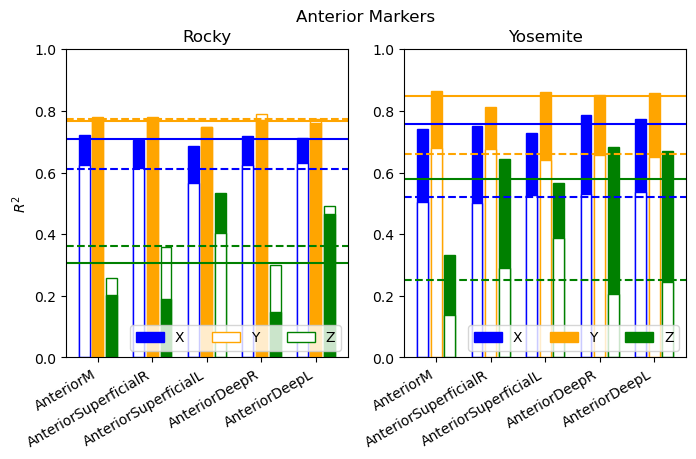

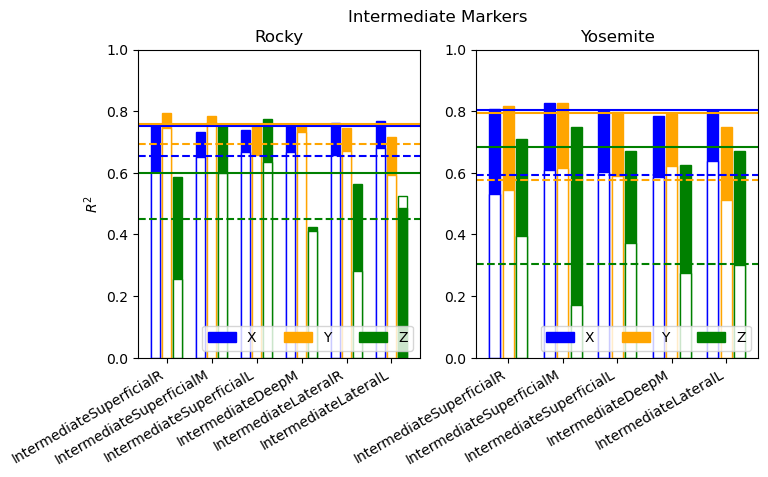

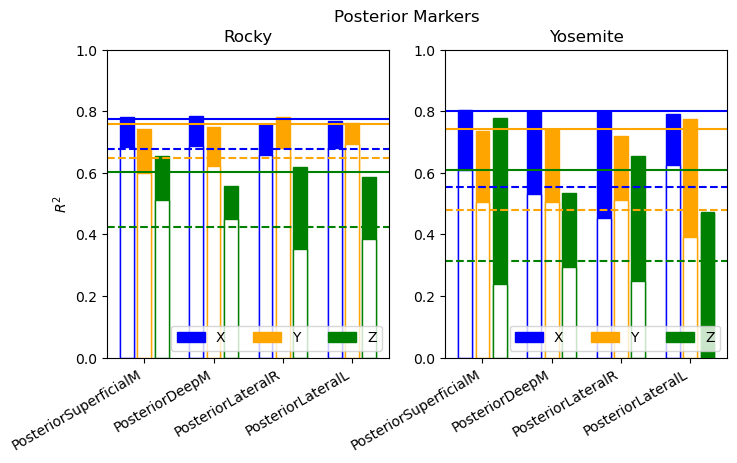

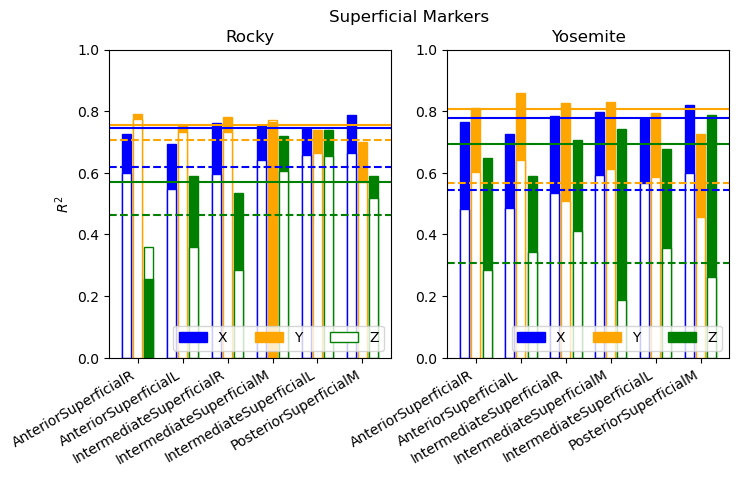

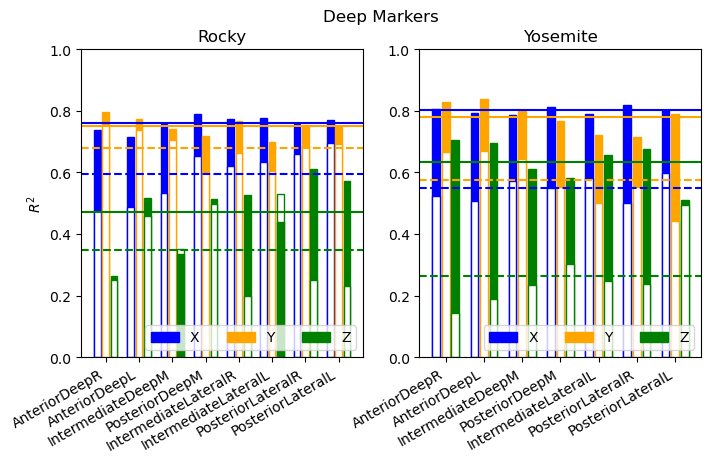

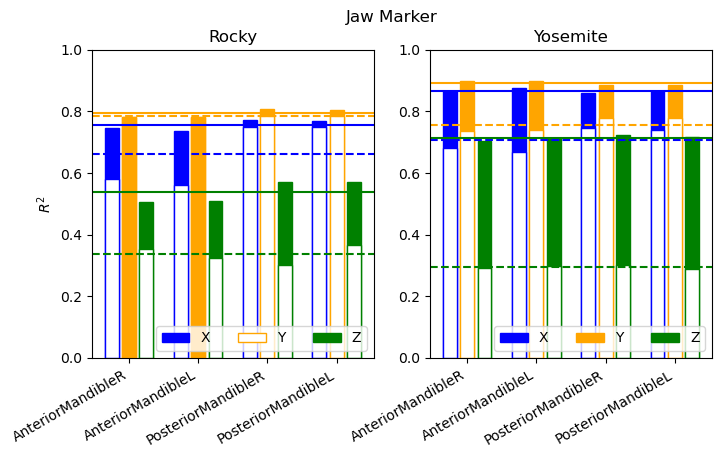

In [45]:
make_plot2(anterior_markers, anterior_markers, region_to_xyz['RC A'], region_to_xyz['RNB A'], region_to_xyz['YC A'], region_to_xyz['YNB A'], 'Anterior Markers', r'$R^{2}$')
make_plot2(r_intermediate_markers, y_intermediate_markers, region_to_xyz['RC I'], region_to_xyz['RNB I'], region_to_xyz['YC I'], region_to_xyz['YNB I'], 'Intermediate Markers', r'$R^{2}$')
make_plot2(posterior_markers, posterior_markers, region_to_xyz['RC P'], region_to_xyz['RNB P'], region_to_xyz['YC P'], region_to_xyz['YNB P'], 'Posterior Markers', r'$R^{2}$')
make_plot2(superficial_markers, superficial_markers, region_to_xyz['RC S'], region_to_xyz['RNB S'], region_to_xyz['YC S'], region_to_xyz['YNB S'], 'Superficial Markers', r'$R^{2}$')
make_plot2(r_deep_markers, y_deep_markers, region_to_xyz['RC D'], region_to_xyz['RNB D'], region_to_xyz['YC D'], region_to_xyz['YNB D'], 'Deep Markers', r'$R^{2}$')
make_plot2(jaw_markers, jaw_markers, region_to_xyz['RC J'], region_to_xyz['RNB J'], region_to_xyz['YC J'], region_to_xyz['YNB J'], 'Jaw Marker', r'$R^{2}$')

## Figure 3

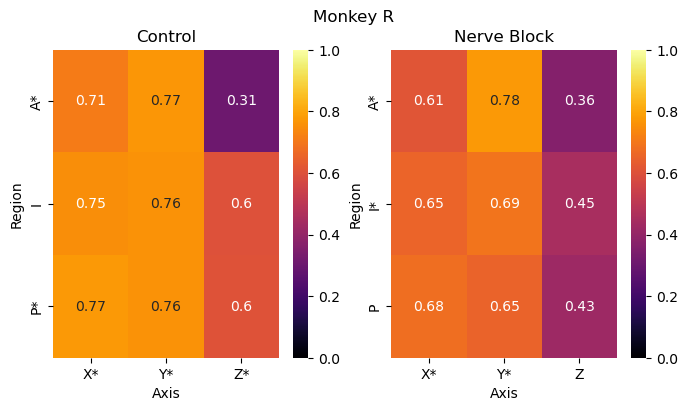

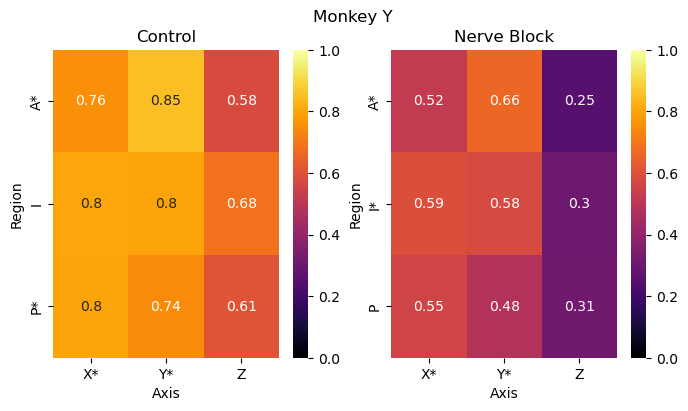

In [46]:
# A vs I vs P
rc_frame = get_frame(['A*', 'I', 'P*'], ['X*', 'Y*', 'Z*'], [region_to_xyz['RC A'], region_to_xyz['RC I'], region_to_xyz['RC P']])
rnb_frame = get_frame(['A*', 'I*', 'P'], ['X*', 'Y*', 'Z'], [region_to_xyz['RNB A'], region_to_xyz['RNB I'], region_to_xyz['RNB P']])
yc_frame = get_frame(['A*', 'I', 'P*'], ['X*', 'Y*', 'Z'], [region_to_xyz['YC A'], region_to_xyz['YC I'], region_to_xyz['YC P']])
ynb_frame = get_frame(['A*', 'I*', 'P'], ['X*', 'Y*', 'Z'], [region_to_xyz['YNB A'], region_to_xyz['YNB I'], region_to_xyz['YNB P']])
make_plot3(rc_frame, rnb_frame, 'Monkey R')
make_plot3(yc_frame, ynb_frame, 'Monkey Y')

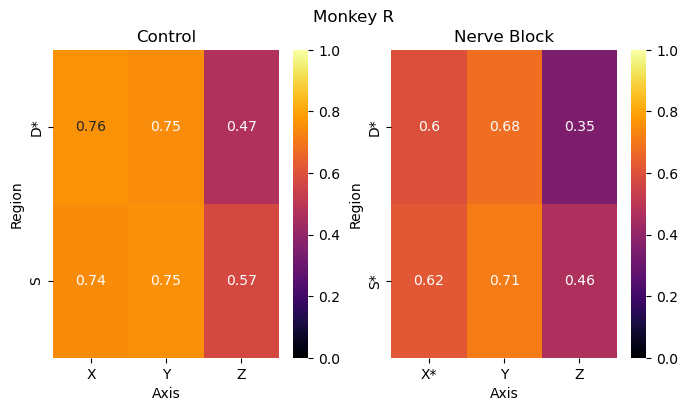

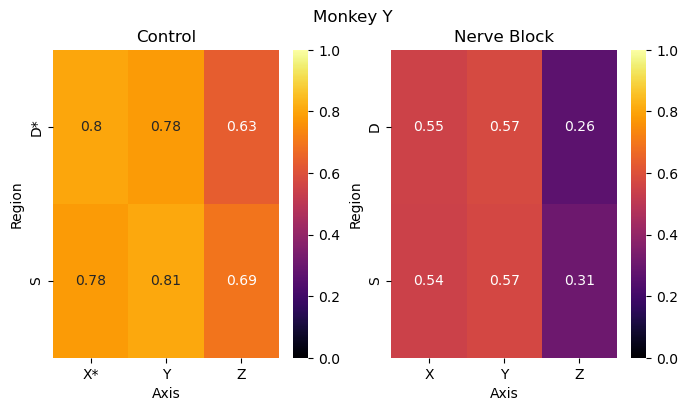

In [47]:
# S vs D
rc_frame = get_frame(['S', 'D*'], ['X', 'Y', 'Z'], [region_to_xyz['RC S'], region_to_xyz['RC D']])
rnb_frame = get_frame(['S*', 'D*'], ['X*', 'Y', 'Z'], [region_to_xyz['RNB S'], region_to_xyz['RNB D']])
yc_frame = get_frame(['S', 'D*'], ['X*', 'Y', 'Z'], [region_to_xyz['YC S'], region_to_xyz['YC D']])
ynb_frame = get_frame(['S', 'D'], ['X', 'Y', 'Z'], [region_to_xyz['YNB S'], region_to_xyz['YNB D']])
make_plot3(rc_frame, rnb_frame, 'Monkey R')
make_plot3(yc_frame, ynb_frame, 'Monkey Y')

## Figure 4

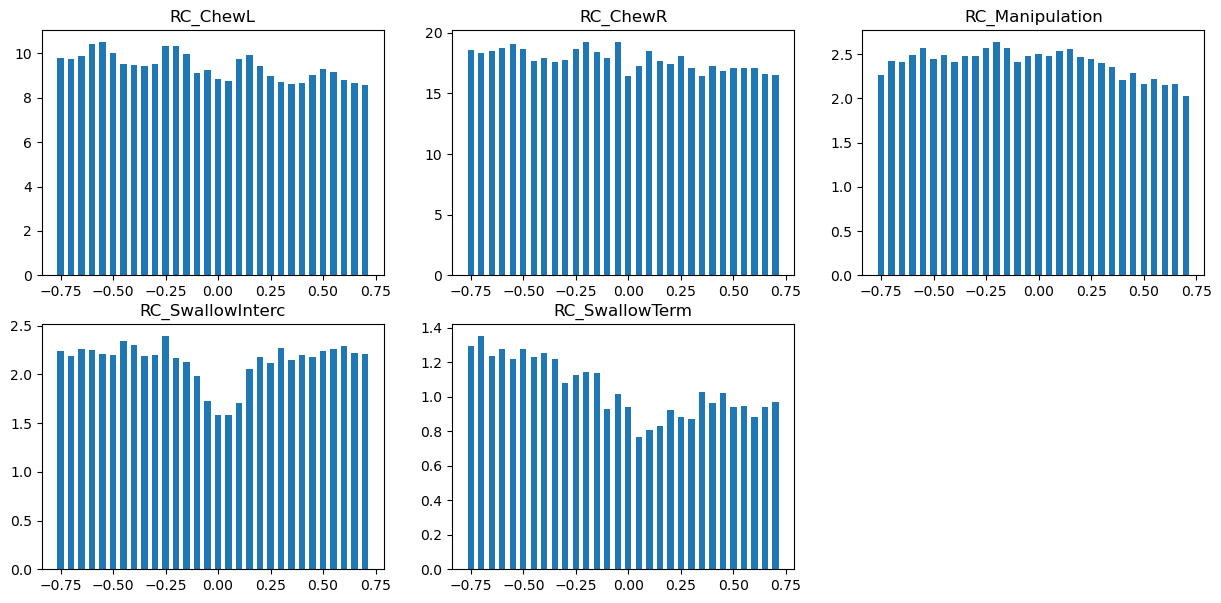

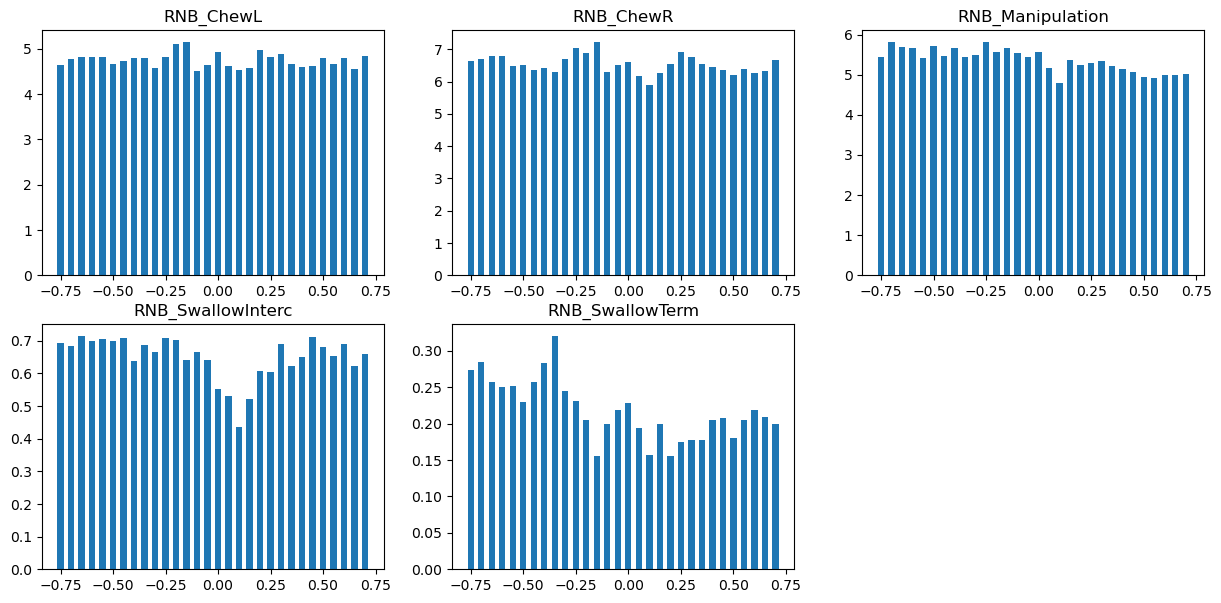

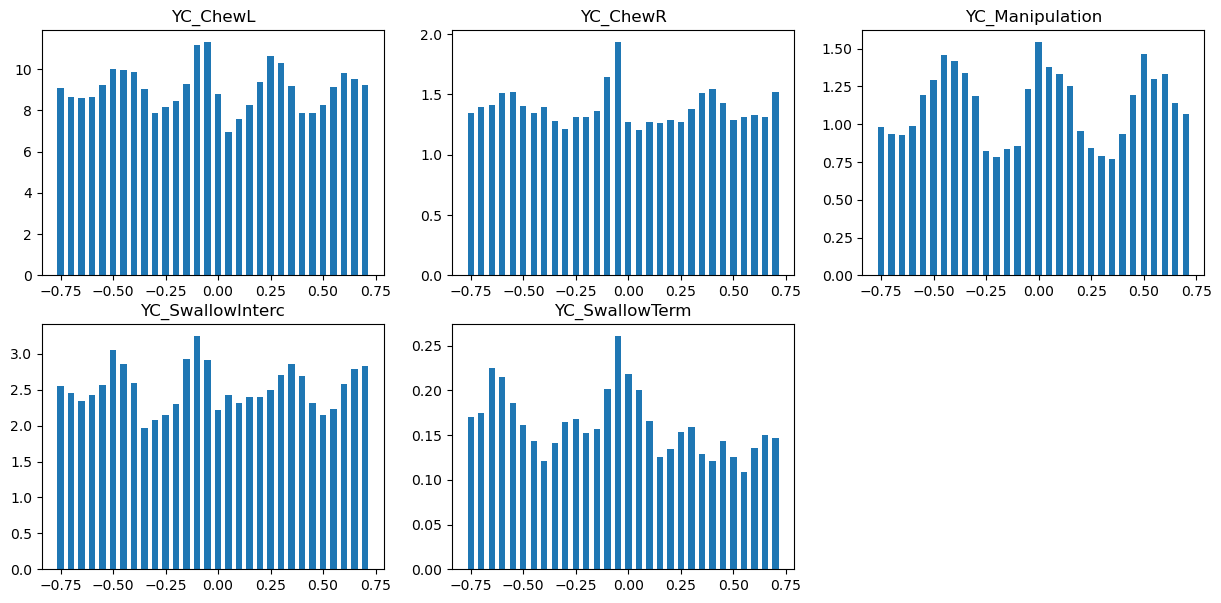

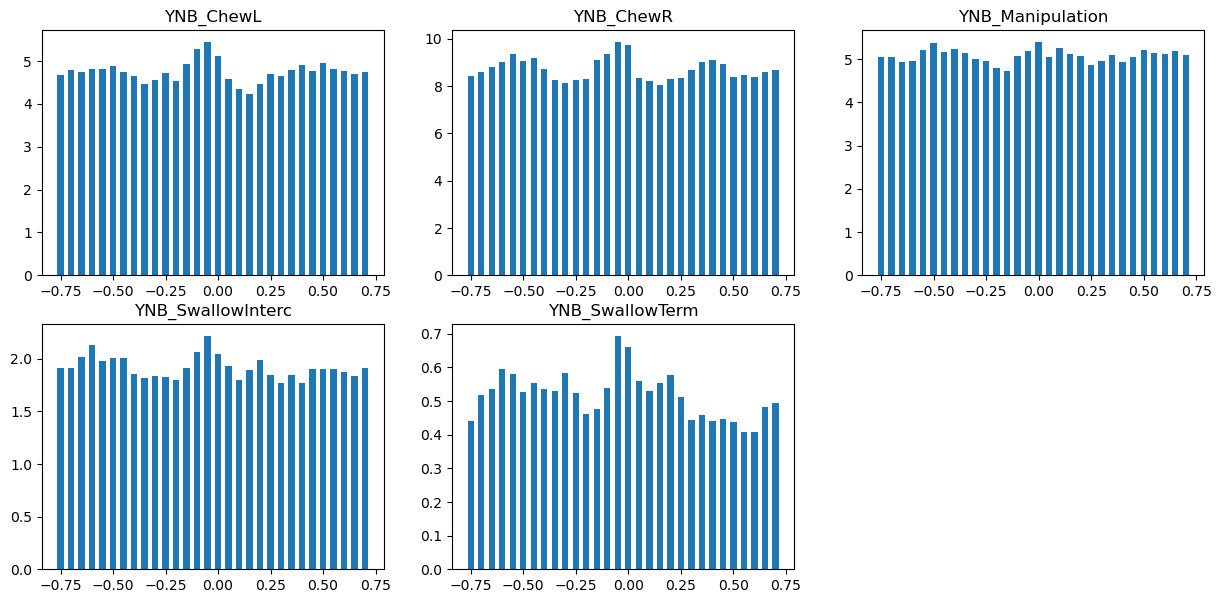

In [67]:
cycles = ["ChewL", "ChewR", "Manipulation", "SwallowInterc", "SwallowTerm"]
cycle_path = "../Real_Decoding/spikesByCycle/"
num_neurons = [29, 27, 28, 29]

def test_cycle(data, cycle):
    if data["cycleType"] != cycle.lower():
        print("Expected: ", cycle)
        print("Real: ", data["cycleType"])
    return

for d_i, d in enumerate(dataset):
    plt.figure(figsize=(15, 7))
    for c_i, c in enumerate(cycles):
        cycle_data = scipy.io.loadmat(cycle_path + d + "_" + c)
        test_cycle(cycle_data, c)
        
        input = None
        neurons = [str(s).split()[1] for s in cycle_data["snrs"]["m1f"][0, 0]]
        for i, neuron in enumerate(neurons):
            neuron_spikes = cycle_data["spikesByGapeCycle"]["m1f"][0, 0][neuron]
            for j in range(neuron_spikes.shape[1]):
                extracted = np.squeeze(neuron_spikes[0, j][0, 0][0], axis=1)
                input = extracted if i == 0 and j == 0 else np.concatenate((input, extracted))
        
        plt.subplot(2, 3, c_i + 1)
        plt.title(d + "_" + c)
        y, x = np.histogram(input, bins=30)
        plt.bar(x[:-1], y / (num_neurons[d_i] * 20), width=0.03)
    plt.show()  

# Tables

## Control vs. Nerve Block

In [49]:
# Mann-Whitney

for i in range(len(xyz)):
    print_stats('Rocky ' + xyz[i], dataset_to_xyz['RC'][xyz[i]], dataset_to_xyz['RNB'][xyz[i]])

for i in range(len(xyz)):
    print_stats('Yosemite ' + xyz[i], dataset_to_xyz['YC'][xyz[i]], dataset_to_xyz['YNB'][xyz[i]])

Rocky X

H Statistic: 839.0
P-Value: 8.008425465352779e-11

Significant

Rocky Y

H Statistic: 640.0
P-Value: 0.0006598642011585655

Significant

Rocky Z

H Statistic: 585.0
P-Value: 0.010759545814437025

Significant

Yosemite X

H Statistic: 729.0
P-Value: 3.030868359795783e-10

Significant

Yosemite Y

H Statistic: 729.0
P-Value: 3.030868359795783e-10

Significant

Yosemite Z

H Statistic: 719.0
P-Value: 9.114511197910234e-10

Significant



## Across Regions

In [50]:
# S vs D Rocky
for i in range(len(xyz)):
    print_stats('RC S vs D ' + xyz[i], region_to_xyz['RC S'][xyz[i]], region_to_xyz['RC D'][xyz[i]])

for i in range(len(xyz)):
    print_stats('RNB S vs D ' + xyz[i], region_to_xyz['RNB S'][xyz[i]], region_to_xyz['RNB D'][xyz[i]])

RC S vs D X

H Statistic: 16.0
P-Value: 0.344988344988345



RC S vs D Y

H Statistic: 27.0
P-Value: 0.7545787545787546



RC S vs D Z

H Statistic: 36.0
P-Value: 0.14185814185814188



RNB S vs D X

H Statistic: 28.0
P-Value: 0.662004662004662



RNB S vs D Y

H Statistic: 31.0
P-Value: 0.4135864135864136



RNB S vs D Z

H Statistic: 37.0
P-Value: 0.1078921078921079





In [51]:
# S vs D Yosemite

for i in range(len(xyz)):
    print_stats('YC S vs D ' + xyz[i], region_to_xyz['YC S'][xyz[i]], region_to_xyz['YC D'][xyz[i]])

for i in range(len(xyz)):
    print_stats('YNB S vs D ' + xyz[i], region_to_xyz['YNB S'][xyz[i]], region_to_xyz['YNB D'][xyz[i]])

YC S vs D X

H Statistic: 10.0
P-Value: 0.13752913752913754



YC S vs D Y

H Statistic: 30.0
P-Value: 0.23426573426573427



YC S vs D Z

H Statistic: 31.0
P-Value: 0.18065268065268064



YNB S vs D X

H Statistic: 20.0
P-Value: 0.9452214452214451



YNB S vs D Y

H Statistic: 19.0
P-Value: 0.8356643356643356



YNB S vs D Z

H Statistic: 29.0
P-Value: 0.2948717948717949





In [52]:
# A vs I vs P Rocky

for i in range(len(xyz)):
    print_stats('RC A vs I vs P ' + xyz[i], region_to_xyz['RC A'][xyz[i]], region_to_xyz['RC I'][xyz[i]], region_to_xyz['RC P'][xyz[i]])

for i in range(len(xyz)):
    print_stats('RNB A vs I vs P ' + xyz[i], region_to_xyz['RNB A'][xyz[i]], region_to_xyz['RNB I'][xyz[i]], region_to_xyz['RNB P'][xyz[i]])

RC A vs I vs P X

H Statistic: 11.458333333333343
P-Value: 0.003249784259075868

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.042     0.000    -0.063    -0.021
 (0 - 2)     -0.065     0.000    -0.089    -0.042
 (1 - 0)      0.042     0.000     0.021     0.063
 (1 - 2)     -0.023     0.047    -0.045    -0.000
 (2 - 0)      0.065     0.000     0.042     0.089
 (2 - 1)      0.023     0.047     0.000     0.045


RC A vs I vs P Y

H Statistic: 0.5933333333333337
P-Value: 0.7432917349842036



RC A vs I vs P Z

H Statistic: 7.360833333333339
P-Value: 0.025212467451569413

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.290     0.012    -0.515    -0.066
 (0 - 2)     -0.296     0.020    -0.545    -0.047
 (1 - 0)      0.290     0.012     0.066     0.515
 (1 - 2)     -0.006     0.998    -0.245     0.234
 (2 - 0)      0.296 

In [53]:
# A vs I vs P Yosemite

for i in range(len(xyz)):
    print_stats('YC A vs I vs P ' + xyz[i], region_to_xyz['YC A'][xyz[i]], region_to_xyz['YC I'][xyz[i]], region_to_xyz['YC P'][xyz[i]])

for i in range(len(xyz)):
    print_stats('YNB A vs I vs P ' + xyz[i], region_to_xyz['YNB A'][xyz[i]], region_to_xyz['YNB I'][xyz[i]], region_to_xyz['YNB P'][xyz[i]])

YC A vs I vs P X

H Statistic: 8.385714285714286
P-Value: 0.01510307153614496

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.048     0.004    -0.078    -0.017
 (0 - 2)     -0.043     0.011    -0.075    -0.011
 (1 - 0)      0.048     0.004     0.017     0.078
 (1 - 2)      0.005     0.915    -0.027     0.037
 (2 - 0)      0.043     0.011     0.011     0.075
 (2 - 1)     -0.005     0.915    -0.037     0.027


YC A vs I vs P Y

H Statistic: 9.985714285714288
P-Value: 0.006786247488324304

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.055     0.016     0.011     0.098
 (0 - 2)      0.106     0.000     0.060     0.153
 (1 - 0)     -0.055     0.016    -0.098    -0.011
 (1 - 2)      0.052     0.030     0.005     0.098
 (2 - 0)     -0.106     0.000    -0.153    -0.060
 (2 - 1)     -0.052     0.030    -0.098    -0.005


Y

## Across Axes of Motion

In [54]:
# S vs D Rocky

print_stats('RC X vs Y vs Z S', region_to_xyz['RC S']['X'], region_to_xyz['RC S']['Y'], region_to_xyz['RC S']['Z'])
print_stats('RC X vs Y vs Z D', region_to_xyz['RC D']['X'], region_to_xyz['RC D']['Y'], region_to_xyz['RC D']['Z'])
print_stats('RNB X vs Y vs Z S', region_to_xyz['RNB S']['X'], region_to_xyz['RNB S']['Y'], region_to_xyz['RNB S']['Z'])
print_stats('RNB X vs Y vs Z D', region_to_xyz['RNB D']['X'], region_to_xyz['RNB D']['Y'], region_to_xyz['RNB D']['Z'])

RC X vs Y vs Z S

H Statistic: 8.187134502923968
P-Value: 0.01667962688240696

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.011     0.981    -0.167     0.145
 (0 - 2)      0.173     0.029     0.017     0.329
 (1 - 0)      0.011     0.981    -0.145     0.167
 (1 - 2)      0.184     0.020     0.028     0.340
 (2 - 0)     -0.173     0.029    -0.329    -0.017
 (2 - 1)     -0.184     0.020    -0.340    -0.028


RC X vs Y vs Z D

H Statistic: 15.605000000000004
P-Value: 0.0004087119208877943

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.010     0.963    -0.082     0.101
 (0 - 2)      0.287     0.000     0.195     0.378
 (1 - 0)     -0.010     0.963    -0.101     0.082
 (1 - 2)      0.277     0.000     0.186     0.368
 (2 - 0)     -0.287     0.000    -0.378    -0.195
 (2 - 1)     -0.277     0.000    -0.368    -0.186



15.704999999999998

In [55]:
# S vs D Yosemite

print_stats('YC X vs Y vs Z S', region_to_xyz['YC S']['X'], region_to_xyz['YC S']['Y'], region_to_xyz['YC S']['Z'])
print_stats('YC X vs Y vs Z D', region_to_xyz['YC D']['X'], region_to_xyz['YC D']['Y'], region_to_xyz['YC D']['Z'])
print_stats('YNB X vs Y vs Z S', region_to_xyz['YNB S']['X'], region_to_xyz['YNB S']['Y'], region_to_xyz['YNB S']['Z'])
print_stats('YNB X vs Y vs Z D', region_to_xyz['YNB D']['X'], region_to_xyz['YNB D']['Y'], region_to_xyz['YNB D']['Z'])

YC X vs Y vs Z S

H Statistic: 8.923976608187132
P-Value: 0.011539396633125455

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.030     0.580    -0.108     0.047
 (0 - 2)      0.086     0.030     0.008     0.163
 (1 - 0)      0.030     0.580    -0.047     0.108
 (1 - 2)      0.116     0.004     0.038     0.194
 (2 - 0)     -0.086     0.030    -0.163    -0.008
 (2 - 1)     -0.116     0.004    -0.194    -0.038


YC X vs Y vs Z D

H Statistic: 13.677179962894257
P-Value: 0.0010716133295510168

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.022     0.693    -0.045     0.089
 (0 - 2)      0.167     0.000     0.100     0.234
 (1 - 0)     -0.022     0.693    -0.089     0.045
 (1 - 2)      0.146     0.000     0.079     0.213
 (2 - 0)     -0.167     0.000    -0.234    -0.100
 (2 - 1)     -0.146     0.000    -0.213    -0.079


12.942486085343234

In [56]:
# A vs I vs P Rocky

print_stats('RC X vs Y vs Z A', region_to_xyz['RC A']['X'], region_to_xyz['RC A']['Y'], region_to_xyz['RC A']['Z'])
print_stats('RC X vs Y vs Z I', region_to_xyz['RC I']['X'], region_to_xyz['RC I']['Y'], region_to_xyz['RC I']['Z'])
print_stats('RC X vs Y vs Z P', region_to_xyz['RC P']['X'], region_to_xyz['RC P']['Y'], region_to_xyz['RC P']['Z'])
print_stats('RNB X vs Y vs Z A', region_to_xyz['RNB A']['X'], region_to_xyz['RNB A']['Y'], region_to_xyz['RNB A']['Z'])
print_stats('RNB X vs Y vs Z I', region_to_xyz['RNB I']['X'], region_to_xyz['RNB I']['Y'], region_to_xyz['RNB I']['Z'])
print_stats('RNB X vs Y vs Z P', region_to_xyz['RNB P']['X'], region_to_xyz['RNB P']['Y'], region_to_xyz['RNB P']['Z'])

RC X vs Y vs Z A

H Statistic: 12.5
P-Value: 0.0019304541362277095

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.059     0.648    -0.233     0.115
 (0 - 2)      0.401     0.000     0.226     0.575
 (1 - 0)      0.059     0.648    -0.115     0.233
 (1 - 2)      0.460     0.000     0.285     0.634
 (2 - 0)     -0.401     0.000    -0.575    -0.226
 (2 - 1)     -0.460     0.000    -0.634    -0.285


RC X vs Y vs Z I

H Statistic: 3.9298245614035068
P-Value: 0.14016818153107724



RC X vs Y vs Z P

H Statistic: 8.346153846153847
P-Value: 0.015404787779972447

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.015     0.725    -0.039     0.070
 (0 - 2)      0.170     0.000     0.115     0.224
 (1 - 0)     -0.015     0.725    -0.070     0.039
 (1 - 2)      0.155     0.000     0.100     0.209
 (2 - 0)     -0.170     0.000   

7.7307692307692335

In [57]:
# A vs I vs P Yosemite

print_stats('YC X vs Y vs Z A', region_to_xyz['YC A']['X'], region_to_xyz['YC A']['Y'], region_to_xyz['YC A']['Z'])
print_stats('YC X vs Y vs Z I', region_to_xyz['YC I']['X'], region_to_xyz['YC I']['Y'], region_to_xyz['YC I']['Z'])
print_stats('YC X vs Y vs Z P', region_to_xyz['YC P']['X'], region_to_xyz['YC P']['Y'], region_to_xyz['YC P']['Z'])
print_stats('YNB X vs Y vs Z A', region_to_xyz['YNB A']['X'], region_to_xyz['YNB A']['Y'], region_to_xyz['YNB A']['Z'])
print_stats('YNB X vs Y vs Z I', region_to_xyz['YNB I']['X'], region_to_xyz['YNB I']['Y'], region_to_xyz['YNB I']['Z'])
print_stats('YNB X vs Y vs Z P', region_to_xyz['YNB P']['X'], region_to_xyz['YNB P']['Y'], region_to_xyz['YNB P']['Z'])

YC X vs Y vs Z A

H Statistic: 12.5
P-Value: 0.0019304541362277095

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.093     0.243    -0.239     0.052
 (0 - 2)      0.177     0.018     0.032     0.323
 (1 - 0)      0.093     0.243    -0.052     0.239
 (1 - 2)      0.270     0.001     0.125     0.416
 (2 - 0)     -0.177     0.018    -0.323    -0.032
 (2 - 1)     -0.270     0.001    -0.416    -0.125


YC X vs Y vs Z I

H Statistic: 8.820000000000007
P-Value: 0.012155178329914893

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.009     0.902    -0.047     0.065
 (0 - 2)      0.119     0.000     0.063     0.176
 (1 - 0)     -0.009     0.902    -0.065     0.047
 (1 - 2)      0.110     0.001     0.054     0.166
 (2 - 0)     -0.119     0.000    -0.176    -0.063
 (2 - 1)     -0.110     0.001    -0.166    -0.054


YC X vs Y vs

6.61538461538462